<a href="https://colab.research.google.com/github/ericbill21/siemens/blob/cleanup/Siemens_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#@title Imports and coinfig
%tensorflow_version 2.x
from IPython.display import clear_output
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import sys
import gc
import logging
import time
#tf.get_logger().setLevel(logging.ERROR)

#time prediciton
prev_time = 0
plt.style.use('seaborn')
tf.random.set_seed(31415)


<Figure size 288x288 with 0 Axes>

In [24]:
#@title Global constants

#Dictionaries
COLORS = {0 : 'green', 1 : 'red', 'green' : 0, 'red' : 1}
SOURCES = {'A' : 'https://drive.google.com/file/d/1hAzAKZNpmSclSI7HnV_cRjpMS4Kh5r1q/view?usp=sharing', 'B' : 'https://drive.google.com/file/d/12VlecL-5iYs-BFpnTOba1x65jWofBX1P/view?usp=sharing', 'C' : 'https://drive.google.com/file/d/1-Z0RuJIi1cZcqrrmV6TqT0O1PwI2OiBY/view?usp=sharing'}
SOURCE_SIZE = {'A': 1000,'B' : 5000, 'C' : 50000}

CURRENT_SET = 'B'

#Examlpe subsets of each dataset
subsetA = [47, 847, 993, 55, 102, 572, 430, 115, 842, 72, 770, 107, 78, 834, 593, 43, 234, 709, 210, 378]
subsetB = [606, 2663, 1809, 2145, 4539, 3333, 3562, 2262, 512, 2046, 1541, 909, 286, 4815, 3663, 1742, 2822, 2756, 2937, 3080, 3845, 3949, 2506, 3984, 2803, 2067]
subsetC = [32088, 33534, 39634, 40177, 25142, 752, 41771, 11793, 16415, 3811, 2096, 35902, 42221, 19594, 25109, 40476, 25162, 41150, 34610, 28329, 46339, 43149, 44441, 25720, 38747, 49497, 12708, 23920, 2280, 17946]

VAL_INDICES = subsetB

#Penalty applied to false green classifications in custom loss function
PENALTY = 0.3

In [37]:
#@title Functions


def getDataSet():
  path = 'https://drive.google.com/uc?export=download&id='+SOURCES[CURRENT_SET].split('/')[-2]
  return pd.read_excel(path)


#Plots the given dataSet in the right colors
def makePlot(dataSet = None, correct_pred_points = [], incorrect_pred_points = []):

  # if optional parameter dataSet is not set
  if dataSet == None:
    dataSet = getDataSet() 

  # Checking for the right type
  if not isinstance(dataSet, pd.DataFrame):
    raise TypeError(f'dataSet is of type: {type(dataSet)}, but should be {pd.DataFrame}')


  # Checking for the right shape 
  if len(np.array(correct_pred_points).shape) != 2 and np.array(correct_pred_points).shape != (0,):
    raise TypeError(f'The shape of the parameter correct_pred_points is: {np.array(correct_pred_points).shape}, but it should be 2 dimensional')
  
  if len(np.array(incorrect_pred_points).shape) != 2 and np.array(incorrect_pred_points).shape != (0,):
    raise TypeError(f'The shape of the parameter incorrect_pred_points is: {np.array(incorrect_pred_points).shape}, but it should be 2 dimensional')
  
  # Creating a subplot
  fig, ax = plt.subplots()

  # Scattering all points
  for i in range(2):
    x_1 = np.array(dataSet['x_i1'].loc[dataSet['l_i'] == i])
    x_2 = np.array(dataSet['x_i2'].loc[dataSet['l_i'] == i])
    ax.scatter(x_1, x_2, c = COLORS[i])


  # Adding markers to the specified points
  ax.scatter(correct_pred_points[:, 0], correct_pred_points[:, 1], marker = "x", c = 'black', label='correct')
  ax.scatter(incorrect_pred_points[:, 0], incorrect_pred_points[:, 1], marker = "*", c = 'black', label='incorrect')


  # Setting parameters for ploting
  plt.legend()
  plt.xlabel('x_i1')
  plt.ylabel('x_i2')
  plt.title(f'DataSet {CURRENT_SET}')
  plt.axis('scaled')
  plt.show()




# Prepares a subset of the dataSet for validation
def seperateValidationSet(dataSet, validationIndices):

  # Cheching for the right type
  if not isinstance(dataSet, pd.DataFrame):
    raise TypeError(f'dataSet is of type: {type(dataSet)}, but should be {pd.DataFrame}')

  # Cheching for the right shape 
  if len(np.array(validationIndices).shape) != 1:
    raise TypeError(f'The shape of the parameter validationIndices is: {np.array(validationIndices).shape}, but it should be 1 dimensional')
  
  valSet_points = []
  valSet_labels = []

  for i in validationIndices:
    valSet_points.append([dataSet['x_i1'].loc[i], dataSet['x_i2'].loc[i]])
    valSet_labels.append([dataSet['l_i'].loc[i]])
  
  #Saving the testing points
  valSet_points = tf.constant(valSet_points, tf.float32)
  valSet_labels = tf.constant(valSet_labels, tf.float32)

  #Removing the testing point
  dataSet.drop(index=validationIndices, inplace=True)
  dataSet.reset_index(inplace=True)

  return (valSet_points, valSet_labels)



# Print iterations progress
def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):

  # Preparing strings
  percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
  filledLength = int(length * iteration // total)
  bar = fill * filledLength + '-' * (length - filledLength)

  # Writing strings to console
  sys.stdout.write(f'\r{prefix} |{bar}| {percent}% ETA: {round(timeCalc()*(total-iteration), 2)} minutes {suffix}')
  sys.stdout.flush()

  # Erease progress bar on complete
  if iteration == total:
    global prev_time
    prev_time = 0
    sys.stdout.write('\r')
    sys.stdout.flush()




def makeCertaintyMap(model, accuracy = 100, specific_color = None):
  accuracy_map = np.zeros((accuracy, accuracy))

  for i in range(accuracy):
    tensor = tf.constant([[j/accuracy, i/accuracy] for j in range(accuracy)], tf.float32)
    result = model.predict(tensor)

    if specific_color != None:
      # Saving the prediction for the specified color
      accuracy_map[i] = result[:, specific_color]
    
    else:
      result = result.max(axis=1) #Getting each max value

      #normalize the values which are between 0.5 <-> 1 to 0 <-> 1
      normalized = (result-0.5)/0.5
      accuracy_map[i] = normalized
  
    # Print current progress
    printProgressBar(i, accuracy-1)


  plt.imshow(accuracy_map, origin='lower', cmap='tab20b', vmin=0, vmax=1)
  plt.colorbar()
  plt.show()
  return accuracy_map




def plotAllPenaltyCombinations(model, accuracy = 100):
  print('Chosen Subset:')
  makePlot(marker=valSet_points.numpy())

  result_x = np.zeros(accuracy+1)
  result_y = np.zeros(accuracy+1)

  printProgressBar(0, accuracy,prefix='Progress', suffix='ETA: ')

  #Iterating over every penalty
  for i in range(accuracy+1):
    keras.backend.clear_session()
    prevTime = time.time()

    penalty = i/accuracy #Selecting a value between 0 and 1 with steps of 1/accuracy

    model.compile(optimizer='adam',loss=construct_custom_penalty_loss(penalty),metrics=['accuracy'])
    model.fit(training_points, training_labels, batch_size=32, epochs=10, shuffle=True, verbose=0)
    
    #Saving results
    result_x[i] = penalty
    result_y[i] = model.evaluate(valSet_points, valSet_labels, verbose=0)[0]

    #Printing progress
    #printProgressBar(i+1, accuracy+1,prefix='Progress')

  #Presenting the results
  print('\nThe loss:')
  plt.plot(result_x, result_y)

  return result_y


def timeCalc():
  global prev_time
  if prev_time == 0:
    prev_time = time.time()
    return 0
  
  res = (time.time() - prev_time) / 60
  prev_time = time.time()
  return res


def plotHistory(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


def showPredicitons(model, valSet_points, valSet_labels):
  # Evaluate the chosen subset
  prediction = model.predict(valSet_points)

  points = valSet_points.numpy()
  labels = valSet_labels.numpy()[:, 0].astype(int)

  # identifying the correct predicted points
  correct_indices = np.where((labels == np.argmax(prediction, axis=1)) == True)
  incorrect_indices = np.where((labels == np.argmax(prediction, axis=1)) == False)

  number_of_points = np.bincount(np.argmax(prediction, axis=1))

  print(f'Predictions for green: {number_of_points[0]} / {len(labels)}')
  print(f'Predictions for red: {number_of_points[1]} / {len(labels)}')
  print(f'The algorithm predicted {np.bincount(labels == np.argmax(prediction, axis=1))[0]} times wrong')
  makePlot(correct_pred_points=points[correct_indices], incorrect_pred_points=points[incorrect_indices])

  return prediction

In [26]:
#Preparing data
dataSet = getDataSet()
dataSet.pop('Unnamed: 0') #Removing unnessary column

valSet_points, valSet_labels = seperateValidationSet(dataSet=dataSet, validationIndices=VAL_INDICES)

#Artificially balancing the dataSet
number_of_green_points = list(dataSet['l_i']).count(COLORS['green'])
number_of_red_points = list(dataSet['l_i']).count(COLORS['red'])

if number_of_red_points / SOURCE_SIZE[CURRENT_SET] <= 0.5:
  amount = int((0.5 - number_of_red_points / SOURCE_SIZE[CURRENT_SET]) * SOURCE_SIZE[CURRENT_SET])
  red_points = dataSet.loc[dataSet['l_i'] == 1] #Getting all red points
  choosen_points = red_points.sample(amount, replace=True) #Selecting a random subset of red points
  dataSet = dataSet.append(choosen_points, ignore_index=True) #appending the subset

if number_of_green_points / SOURCE_SIZE[CURRENT_SET] <= 0.5:
  amount = int((0.5 - number_of_green_points / SOURCE_SIZE[CURRENT_SET]) * SOURCE_SIZE[CURRENT_SET])
  green_points = dataSet.loc[dataSet['l_i'] == 0] #Getting all green points
  choosen_points = green_points.sample(amount, replace=True) #Selecting a random subset of green points
  dataSet = dataSet.append(choosen_points, ignore_index=True) #appending green subset

if 'index' in dataSet.columns:
  dataSet.pop('index') #removing old indices
  print(f'Artificially exended by {dataSet["x_i1"].size - SOURCE_SIZE[CURRENT_SET] + len(VAL_INDICES)} points')
  print(f'Relation is now: {dataSet.loc[dataSet["l_i"] == 0].shape[0]} green  : {dataSet.loc[dataSet["l_i"] == 1].shape[0]} red ')

#Creating tensors
training_labels = tf.constant(dataSet.pop('l_i'), tf.float32)
training_points = tf.constant(dataSet, tf.float32)

Artificially exended by 140 points
Relation is now: 2500 green  : 2614 red 


In [27]:
def construct_custom_penalty_loss(penalty=PENALTY):

  def custom_penalty_loss(y_true,y_pred):
    length = tf.shape(y_true)[0]

    #Creating a vector with all values set to the penalty: [0.3, 0.3, ... 0.3]
    error = tf.multiply(tf.constant(penalty, tf.float32), tf.ones(length)) 

    #Setting every entry to 0 if the corresponding entry in y_true is 1
    error = tf.where(tf.equal(y_true[:, 0], tf.zeros(length)), error, tf.zeros(length))

    #Setting every entry to 0 if the algorithm predicted 0
    error = tf.where(tf.greater(y_pred[:, 0], y_pred[:, 1]), tf.zeros(length), error)

    #Transforms the vector from [0, 0, 0.3, ... 0,3] to [[0, -0], [0, -0], [0.3, -0.3], ... [0.3, -0.3]]
    error = tf.stack([error, tf.multiply(tf.constant(-1, tf.float32), error)], 1)

    #Adding the artificial loss
    y_pred = y_pred + error

    #Eliminating values > 1 or < 0
    y_pred0 = tf.where(tf.greater(y_pred[:, 0], tf.ones(length)), tf.ones(length), y_pred[:, 0])
    y_pred1 = tf.where(tf.greater(y_pred[:, 1], tf.zeros(length)), y_pred[:, 1], tf.zeros(length))
    y_pred = tf.stack([y_pred0, y_pred1], axis=1)


    loss = keras.losses.sparse_categorical_crossentropy(y_pred=y_pred, y_true=y_true)
    return loss
  
  return custom_penalty_loss

In [39]:
initalizer = keras.initializers.GlorotNormal()

model = keras.Sequential([
           keras.layers.Flatten(input_shape=(2,)),      #input layer: 2 neurons
           keras.layers.Dense(100,activation='relu', kernel_initializer=initalizer), 
           keras.layers.Dense(70,activation='relu', kernel_initializer=initalizer), 
           keras.layers.Dense(50,activation='relu', kernel_initializer=initalizer),       
           keras.layers.Dense(10,activation='relu', kernel_initializer=initalizer),
           keras.layers.Dense(2,activation='softmax', kernel_initializer=initalizer)   #output layer: 2 neurons              
])


model.compile(optimizer='adam',loss=construct_custom_penalty_loss(PENALTY) ,metrics=['accuracy'])


history = model.fit(training_points, training_labels, batch_size=32, epochs=100, shuffle=True, validation_data=(valSet_points, valSet_labels))

Epoch 1/100
160/160 [==============================] - 1s 4ms/step - loss: 0.4003 - accuracy: 0.6080 - val_loss: 0.5254 - val_accuracy: 0.5769
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2448 - accuracy: 0.8335 - val_loss: 0.5845 - val_accuracy: 0.6923
Epoch 3/100
160/160 [==============================] - 0s 3ms/step - loss: 0.2217 - accuracy: 0.8453 - val_loss: 0.6303 - val_accuracy: 0.6538
Epoch 4/100
160/160 [==============================] - 0s 3ms/step - loss: 0.2178 - accuracy: 0.8452 - val_loss: 0.4808 - val_accuracy: 0.5769
Epoch 5/100
160/160 [==============================] - 0s 3ms/step - loss: 0.2139 - accuracy: 0.8503 - val_loss: 0.5896 - val_accuracy: 0.6923
Epoch 6/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.8390 - val_loss: 0.6255 - val_accuracy: 0.6538
Epoch 7/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2259 - accuracy: 0.8416 - val_loss: 0.5919 - val_accuracy: 0.6923

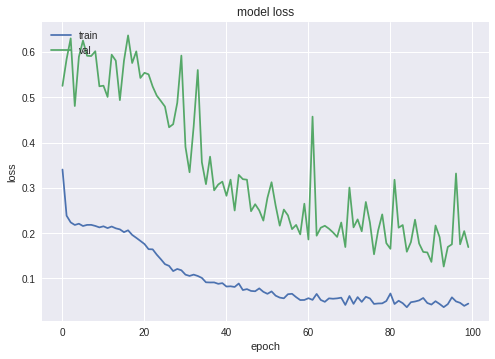

Predictions for green: 13 / 26
Predictions for red: 13 / 26
The algorithm predicted 3 times wrong


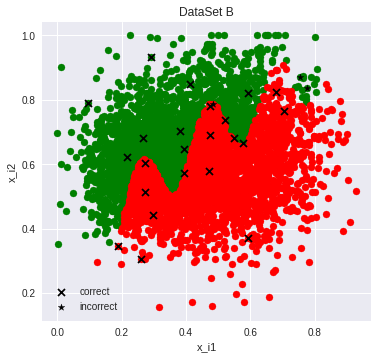

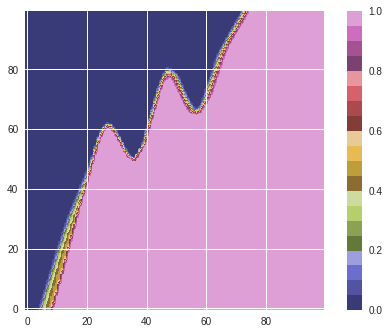

In [40]:
plotHistory(history)
x = showPredicitons(model, valSet_points, valSet_labels)
y = makeCertaintyMap(model, specific_color=1)